### After you have saved the image's pred_mask into a gzip file

In [1]:
import gzip
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np


resize_transforms = transforms.Compose([
    transforms.Resize((32,32)),
]) # Resizes the pred_mask
img_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
]) # Resizes the img and converts to tensor

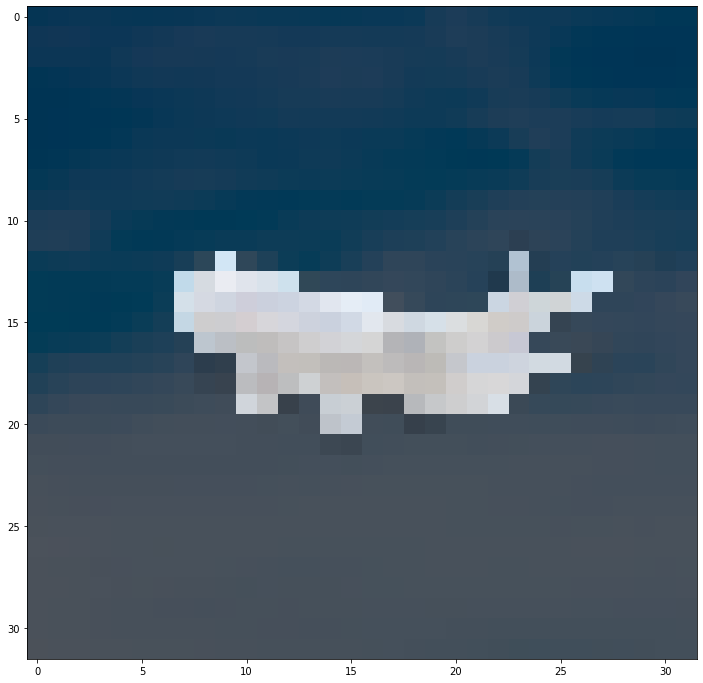

In [2]:
# load in the image
img = Image.open("/path/to/img.jpg")

transformed_img = img_transforms(img)

# load in the pred_mask gzip file
with gzip.open("pred_masks.gzip", 'rb') as fobj:
    x = BytesIO(fobj.read())
    preds_dict = torch.load(x)
    
index = 0 # the index of the most prominent segmentation change this to look at other segment

pred = preds_dict["pred_masks"][index]
resized_pred_mask = resize_transforms(pred.reshape(1,pred.shape[0],pred.shape[1])) # reshape to 1, 32, 32

# reshape to 32, 32 and convert to numpy array
pred_array = resized_pred_mask.reshape(32,32).numpy().astype(np.uint8)


plt.rcParams["figure.figsize"] = (12,12) # set fig size
fig = plt.figure()
ax = fig.add_subplot(111)

plt.imshow(transformed_img.permute(1,2,0))

#ax.imshow(pred_array, aspect='auto', cmap="YlGnBu_r", interpolation='nearest', alpha=0.6)
ax.imshow(pred_array, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', alpha=0.6)
plt.savefig('segmented_airplane.png',bbox_inches='tight')

### Plotting integrated gradients results on top of this image

In [21]:
from captum.attr import visualization as viz
import numpy as np
import PIL.ImageShow

In [22]:
# Load in the integrated gradients results

with gzip.open("output_attributions.gzip", 'rb') as fobj:
    x = BytesIO(fobj.read())
    grads_dict = torch.load(x)
     
attr_ig = grads_dict["integrated_grads"].astype(np.float64)

# load in the image we just made for the background
segment_image = Image.open("segmented_airplane.png").convert('RGB')
segment_image_tensor = img_transforms(segment_image).permute(1,2,0).numpy().astype(np.float64)


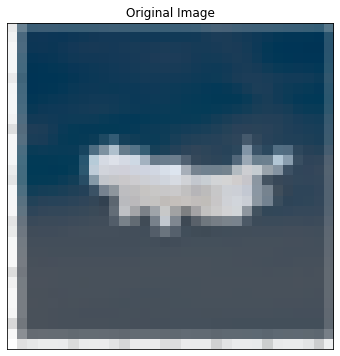

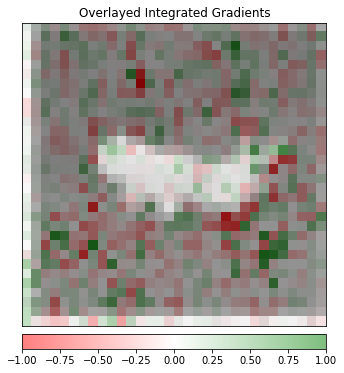

(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:title={'center':'Overlayed Integrated Gradients'}>)

In [26]:
viz.visualize_image_attr(None, segment_image_tensor, 
                      method="original_image", title="Original Image")

viz.visualize_image_attr(attr_ig, segment_image_tensor, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients", alpha_overlay=0.5)